In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
%matplotlib inline
sys.path.append('/Users/palmer/Documents/python_codebase/')
from pyImagingMSpec.hdf5.IMSdataset import IMSdataset
from pyMS import centroid_detection
from pyImzML import ImzMLParser
import h5py
import datetime
import numpy as np
from IPython.display import display, clear_output
import scipy.signal as signal

the idea is to load each spectrum one-at-a-time and then randomise the intensities across the existing m/zs. another version of this could add some random offset to each m/z.

not sure if it's best to randomise intensities each spectrum or mzs across the whole dataset

In [2]:
from pyImagingMSpec.hdf5.inMemoryIMS_hdf5 import inMemoryIMS_hdf5
### Provide file names
filename_IMShdf5_in = '/Users/palmer/Documents/tmp_data/RatBrain_IMS/RatBrain_2013_09_20_centroids_IMS.hdf5'
filename_IMShdf5_out = '/Users/palmer/Documents/tmp_data/RatBrain_IMS/RatBrain_2013_09_20_centroids_IMS_RB2_rotated1.hdf5'

### Open files
#create file, truncate if exists
IMS_dataset=inMemoryIMS_hdf5(filename_IMShdf5_in)

loaded spectra
file loaded


/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
filename_IMShdf5_out = '/Users/palmer/Documents/tmp_data/RatBrain_IMS/RatBrain_2013_09_20_centroids_IMS_RB2_rotated2.hdf5'

with h5py.File(filename_IMShdf5_out,'w') as f_out:
    #with h5py.File(filename_IMShdf5_in,'r') as f_in:
    ### Provide some file info
    # note, there is support for multiple sample types within a file but the code must be updated.
    sample_name = 'Rat Brain' 
    sample_source = 'Palmer'
    sample_preparation = 'thin section on ITO slide'
    maldi_matrix = 'DHB'
    matrix_application = 'sublimation'
    ### Open files
    ### make root groups for output data
    spectral_data = f_out.create_group('spectral_data')
    spatial_data = f_out.create_group('spatial_data')
    shared_data = f_out.create_group('shared_data')

    ### populate common variables - can hardcode as I know what these are for h5 data
    # parameters
    instrument_parameters_1 = shared_data.create_group('instrument_parameters/001')
    instrument_parameters_1.attrs['instrument name'] = 'Solarix'
    instrument_parameters_1.attrs['analyser type'] = 'Bruker'
    instrument_parameters_1.attrs['data conversion'] = 'hdf5->hdf5 randomised:'+str(datetime.datetime.now())
    # m/z axis
        #will centroid data so this doesn't exist
    # ROIs
        #todo - determine and propagate all ROIs
    roi_1 = shared_data.create_group('regions_of_interest/001')
    roi_1.attrs['name'] = 'root region'
    roi_1.attrs['parent'] = ''
    # Sample
        #todo - not write empty properties
    sample_1 = shared_data.create_group('samples/001')
    sample_1.attrs['name'] = sample_name
    sample_1.attrs['source'] = sample_source
    sample_1.attrs['preparation'] = sample_preparation
    sample_1.attrs['MALDI matrix'] = maldi_matrix
    sample_1.attrs['MALDI matrix application'] = matrix_application

    ### write spectra

    n=0;
    for i,idx in enumerate(IMS_dataset.index_list):
        ## rename as I'm using old code :S
        spot = i
        key=str(idx)
        coords = IMS_dataset.coords[idx]

        ## make new spectrum
        spec=IMS_dataset.get_spectrum(idx)
        mzs_list,intensity_list = spec.get_spectrum(source='centroids')
        intensity_offset = np.random.randint(0,len(intensity_list))
        #intensity_offset=0
        intensity_list = list(intensity_list)
        intensity_list = np.asarray(intensity_list[intensity_offset:] + intensity_list[:intensity_offset])

        # add intensities
        this_spectrum = spectral_data.create_group(key)
        try:
            this_intensities = this_spectrum.create_dataset('centroid_intensities',data=np.float32(intensity_list),compression="gzip",compression_opts=9)
        except:
            print ints
            print intensity_list
            raise
        # add coordinates
        if len(coords)==2:
            coords = (coords[0],coords[1],0)
        this_coordiantes = this_spectrum.create_dataset('coordinates',data=(coords[0],coords[1],coords[2]))
        ## link to shared parameters
        # mzs
        this_mzs = this_spectrum.create_dataset('centroid_mzs',data=np.float64(mzs_list),compression="gzip",compression_opts=9)

        ###
        # ROI
        this_spectrum['ROIs/001'] = h5py.SoftLink('/shared_data/regions_of_interest/001')
        # Sample
        this_spectrum['samples/001'] = h5py.SoftLink('/shared_data/samples/001')
        # Instrument config
        this_spectrum['instrument_parameters'] = h5py.SoftLink('/shared_data/instrument_parameters/001')
        n+=1
        if np.mod(n,10)==0:
            clear_output(wait=True)
            print '{:3.2f}\% complete\r'.format(100.*n/len(IMS_dataset.coords),end="\r")
            sys.stdout.flush()

print 'fin'

99.93\% complete
fin


In [19]:
### Open result files
IMS_dataset_out=inMemoryIMS_hdf5(filename_IMShdf5_out)

loaded spectra
file loaded


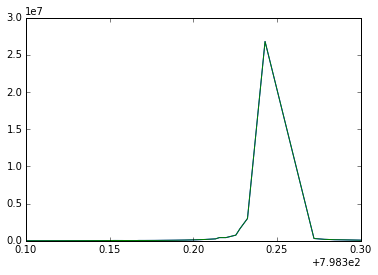

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
spec_idx=1
spec=IMS_dataset.get_spectrum(IMS_dataset.index_list[521])
mzs_list,intensity_list = spec.get_spectrum(source='centroids')

plt.figure()

plt.plot(mzs_list,intensity_list)

spec=IMS_dataset.get_spectrum(IMS_dataset_out.index_list[521])
mzs_list,intensity_list = spec.get_spectrum(source='centroids')
plt.plot(mzs_list,intensity_list)

plt.xlim((798.4,798.6))
plt.show()

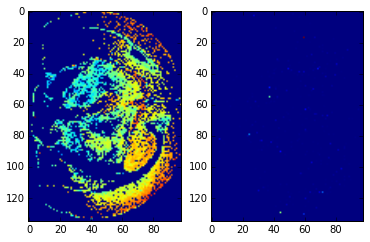

[array([ 19953840.,         0.,         0., ...,         0.,         0.,
               0.])]
[array([ 1959.90869141,     0.        ,     0.        , ...,     0.        ,
           0.        ,     0.        ])]


In [20]:
# View the output from a specific metabolite
import numpy as np
import matplotlib.pyplot as plt
from pySpatialMetabolomics.tools import results_tools
%matplotlib inline
sum_formula='C12H18O8' #798.5409668
adduct = 'H'
q_val=100
ppm=1.

ion_datacube_in = IMS_dataset.get_ion_image(np.asarray([798.5409668,]),ppm)
ion_datacube_out = IMS_dataset_out.get_ion_image(np.asarray([798.5409668,]),ppm)

ion_datacube_out.coord_to_index()
f,ax = plt.subplots(1,2)
ax[0].imshow(ion_datacube_in.xic_to_image(0))
ax[1].imshow(ion_datacube_out.xic_to_image(0))
plt.show()
print ion_datacube_in.xic
print ion_datacube_out.xic